In [4]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.0)

In [5]:
DATA_ROOT = r"C:\Users\HP\Downloads\dataset"

# Mapping activity folder names to labels
activity_map = {
    "a01": "sitting",
    "a02": "standing",
    "a03": "lying_on_back",
    "a04": "lying_on_right_side",
    "a05": "ascending_stairs",
    "a06": "descending_stairs",
    "a07": "standing_in_elevator_still",
    "a08": "moving_in_elevator",
    "a09": "walking_in_parking_lot",
    "a10": "walking_on_treadmill_flat_4kmh",
    "a11": "walking_on_treadmill_incline_4kmh",
    "a12": "running_on_treadmill_8kmh",
    "a13": "exercising_on_stepper",
    "a14": "exercising_on_cross_trainer",
    "a15": "cycling_horizontal",
    "a16": "cycling_vertical",
    "a17": "rowing",
    "a18": "jumping",
    "a19": "playing_basketball",
}

In [6]:
def extract_features(segment_array):
    means = np.mean(segment_array, axis=0)
    stds = np.std(segment_array, axis=0)
    mins = np.min(segment_array, axis=0)
    maxs = np.max(segment_array, axis=0)
    return np.concatenate([means, stds, mins, maxs])

def generate_feature_names():
    units = ["T", "RA", "LA", "RL", "LL"]
    sensors = ["xacc", "yacc", "zacc", "xgyro", "ygyro", "zgyro", "xmag", "ymag", "zmag"]
    stats = ["mean", "std", "min", "max"]

    feature_names = []
    for stat in stats:
        for unit in units:
            for sensor in sensors:
                feature_names.append(f"{unit}{sensor}{stat}")

    return feature_names

feature_names = generate_feature_names()
len(feature_names)

180

In [7]:
all_rows = []

for a_folder, activity_label in activity_map.items():
    activity_dir = os.path.join(DATA_ROOT, a_folder)
    if not os.path.isdir(activity_dir):
        print("Missing folder:", activity_dir)
        continue

    for subject_id in range(1, 9):  # subjects p1–p8
        subject_dir = os.path.join(activity_dir, f"p{subject_id}")
        if not os.path.isdir(subject_dir):
            continue

        for seg_id in range(1, 61):  # segments s01–s60
            file_path = os.path.join(subject_dir, f"s{seg_id:02d}.txt")
            if not os.path.isfile(file_path):
                continue

            segment = np.loadtxt(file_path, delimiter=",")

            if segment.shape != (125, 45):
                print("Wrong shape:", segment.shape)
                continue

            features = extract_features(segment)

            row = {fname: f for fname, f in zip(feature_names, features)}
            row["activity"] = activity_label
            row["activity_id"] = a_folder
            row["subject"] = subject_id
            row["segment"] = seg_id

            all_rows.append(row)

data = pd.DataFrame(all_rows)
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (9120, 184)


,Txaccmean,Tyaccmean,Tzaccmean,Txgyromean,Tygyromean,Tzgyromean,Txmagmean,Tymagmean,Tzmagmean,RAxaccmean,...,LLxgyromax,LLygyromax,LLzgyromax,LLxmagmax,LLymagmax,LLzmagmax,activity,activity_id,subject,segment
0,7.975714,1.083150,5.606846,0.004897,0.026123,-0.003726,-0.790726,-0.068490,0.135897,0.679134,...,0.015853,0.020288,0.013777,0.74238,0.30342,-0.054963,sitting,a01,1,1
1,7.978250,1.140865,5.598922,0.003308,0.022514,-0.003240,-0.791962,-0.070157,0.137123,0.644964,...,0.012283,0.020459,0.011976,0.74335,0.30390,-0.054945,sitting,a01,1,2
2,7.970894,1.140962,5.607750,0.001846,0.018806,-0.003486,-0.792875,-0.070723,0.136436,0.608212,...,0.010339,0.020252,0.012057,0.74316,0.30423,-0.054711,sitting,a01,1,3
3,7.938412,1.165260,5.648969,0.003788,0.023768,-0.003512,-0.793550,-0.071969,0.131983,0.591138,...,0.012145,0.019706,0.019284,0.74313,0.30416,-0.053670,sitting,a01,1,4
4,7.908930,1.187504,5.680980,0.001086,0.012242,-0.002488,-0.793872,-0.072597,0.128345,0.558168,...,0.013583,0.019461,0.013865,0.74298,0.30503,-0.053313,sitting,a01,1,5


In [9]:
meta_cols = ["activity", "activity_id", "subject", "segment"]

X = data.drop(columns=meta_cols)
y = data["activity"]

X.shape, y.shape

((9120, 180), (9120,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [11]:
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("clf", SVC())
])

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("clf", KNeighborsClassifier())
])

dt_pipe = Pipeline([
    ("clf", DecisionTreeClassifier(random_state=42))
])

In [12]:
svm_params = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.001],
    "clf__kernel": ["rbf"]
}

knn_params = {
    "clf__n_neighbors": [3, 5, 7, 11],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["euclidean", "manhattan"]
}

dt_params = {
    "clf__max_depth": [None, 10, 20, 40],
    "clf__criterion": ["gini", "entropy"],
    "clf__min_samples_split": [2, 5, 10]
}

In [13]:
def train_and_evaluate(name, pipeline, param_grid):
    print(f"\n===== {name} =====")

    grid = GridSearchCV(
        pipeline, param_grid, cv=5,
        scoring="f1_macro", n_jobs=-1
    )
    grid.fit(X_train, y_train)

    print("Best Params:", grid.best_params_)
    print("Best CV F1:", grid.best_score_)

    y_pred = grid.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print("Test Accuracy:", acc)
    print("Macro F1 Score:", f1)

    # CONFUSION MATRIX PLOT
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues",
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.title(f"{name} Confusion Matrix")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    return grid, acc, f1


===== SVM =====
Best Params: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV F1: 0.9914527123518116
Test Accuracy: 0.993421052631579
Macro F1 Score: 0.9934163438946456


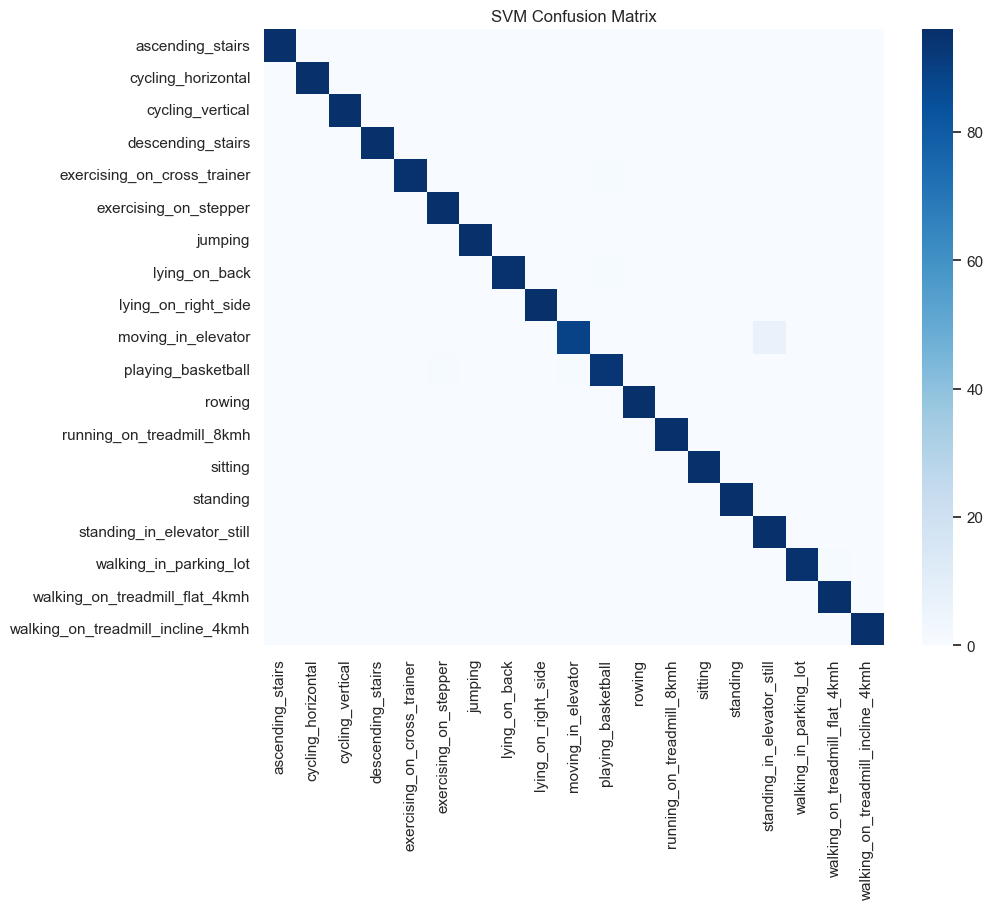


===== KNN =====


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.98331476 0.98346522 0.98000467 0.98186722 0.97919373 0.9809415
 0.97540466 0.9779266         nan 0.98285192        nan 0.98234945
        nan 0.97974348        nan 0.9766321 ]
  warnings.warn(


Best Params: {'clf__metric': 'euclidean', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Best CV F1: 0.983465220636285


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\HP\AppData\Local

Test Accuracy: 0.9890350877192983
Macro F1 Score: 0.9889521397554948


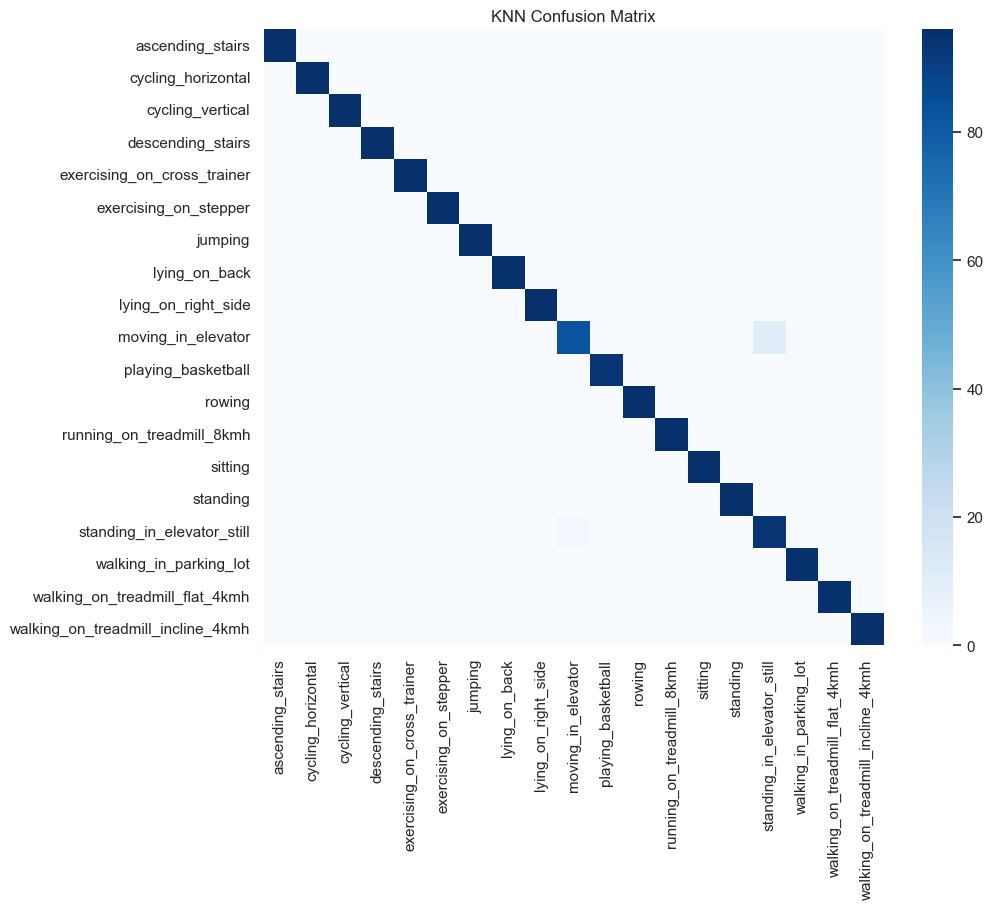


===== Decision Tree =====
Best Params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 5}
Best CV F1: 0.9731656530291481
Test Accuracy: 0.9797149122807017
Macro F1 Score: 0.9795026048422132


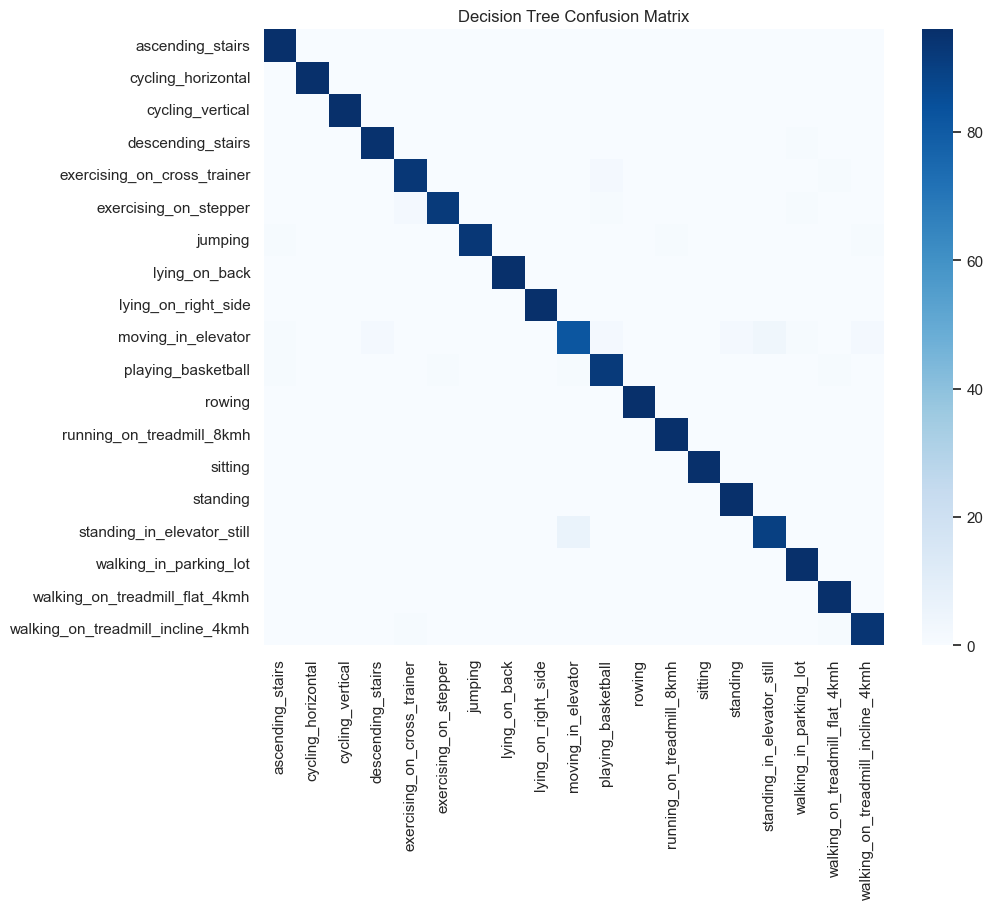

SVM        → Acc: 0.9934, F1: 0.9934
KNN        → Acc: 0.9890, F1: 0.9890
DecisionTree → Acc: 0.9797, F1: 0.9795


In [14]:
svm_best, svm_acc, svm_f1 = train_and_evaluate("SVM", svm_pipe, svm_params)
knn_best, knn_acc, knn_f1 = train_and_evaluate("KNN", knn_pipe, knn_params)
dt_best, dt_acc, dt_f1   = train_and_evaluate("Decision Tree", dt_pipe, dt_params)

print(f"SVM        → Acc: {svm_acc:.4f}, F1: {svm_f1:.4f}")
print(f"KNN        → Acc: {knn_acc:.4f}, F1: {knn_f1:.4f}")
print(f"DecisionTree → Acc: {dt_acc:.4f}, F1: {dt_f1:.4f}")

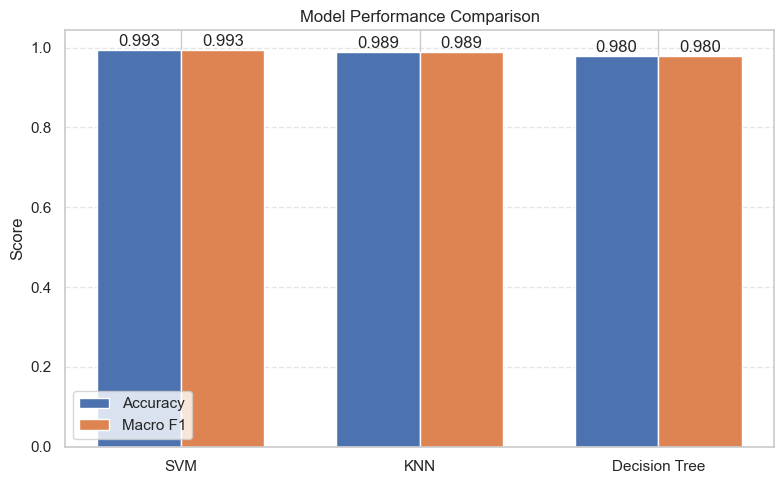

In [16]:
import numpy as np

models = ["SVM", "KNN", "Decision Tree"]
accs = np.array([svm_acc, knn_acc, dt_acc])
f1s  = np.array([svm_f1,  knn_f1,  dt_f1])

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, accs, width, label='Accuracy')
plt.bar(x + width/2, f1s, width, label='Macro F1')

plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(x, models)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Value labels
for i, v in enumerate(accs):
    plt.text(i - width/2, v + 0.01, f"{v:.3f}", ha="center")
for i, v in enumerate(f1s):
    plt.text(i + width/2, v + 0.01, f"{v:.3f}", ha="center")

plt.tight_layout()
plt.show()
